In [1]:
import sys
sys.path.append("../")

from scripts.direct_training import direct_training
import matplotlib.pyplot as plt
from plotting_utils import style_defaults, log_log
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update(style_defaults)


direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="Si-GAP-18",
        labels="dft",
        r_max=4,
    )
).groupby("n_train").min(numeric_only=True).reset_index().sort_values("n_train")
direct_results[["n_train", "test_force_rmse"]]

,n_train,test_force_rmse
0,25,0.245748
1,50,0.215838
2,100,0.184374
3,200,0.160873
4,400,0.141391
5,800,0.123067
6,1600,0.108583


In [2]:
from scripts.alchemical_train import alchemical_train
from scripts.fine_tuning import fine_tuning
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


def add_finetune_results(pretrain_config, ax, color="hotpink"):
    pretrained_results = alchemical_train.to_dataframe(
        config=pretrain_config
    ).sort_values("n_train")
    pretrained_models = {row.n_train: row.id for row in pretrained_results.itertuples()}

    n_pretrains = [100, 330, 1_000, 3_300, 10_000]
    cmap = LinearSegmentedColormap.from_list("mycmap", ["white", color])

    gradient = cmap(np.linspace(0.2, 1, len(n_pretrains)))
    color_gradient = dict(zip(n_pretrains, gradient))

    finetuned_results = {}
    for label, id in pretrained_models.items():
        try:
            finetuned_results[label] = (
                fine_tuning.to_dataframe(
                    config=dict(
                        pretrain_id=id,
                        finetune_dataset="Si-GAP-18",
                        finetune_labels="dft",
                        r_max=4,
                    )
                )
                .groupby("n_finetune")
                .min(numeric_only=True)
                .reset_index()
            )

        except:
            print(f"Skipping {label}")

    for n_pretrain, results in finetuned_results.items():
        ax.plot(
            results.n_finetune,
            results.test_force_rmse,
            "-o",
            color=color_gradient[n_pretrain],
            label=f"{n_pretrain:,}",
        )


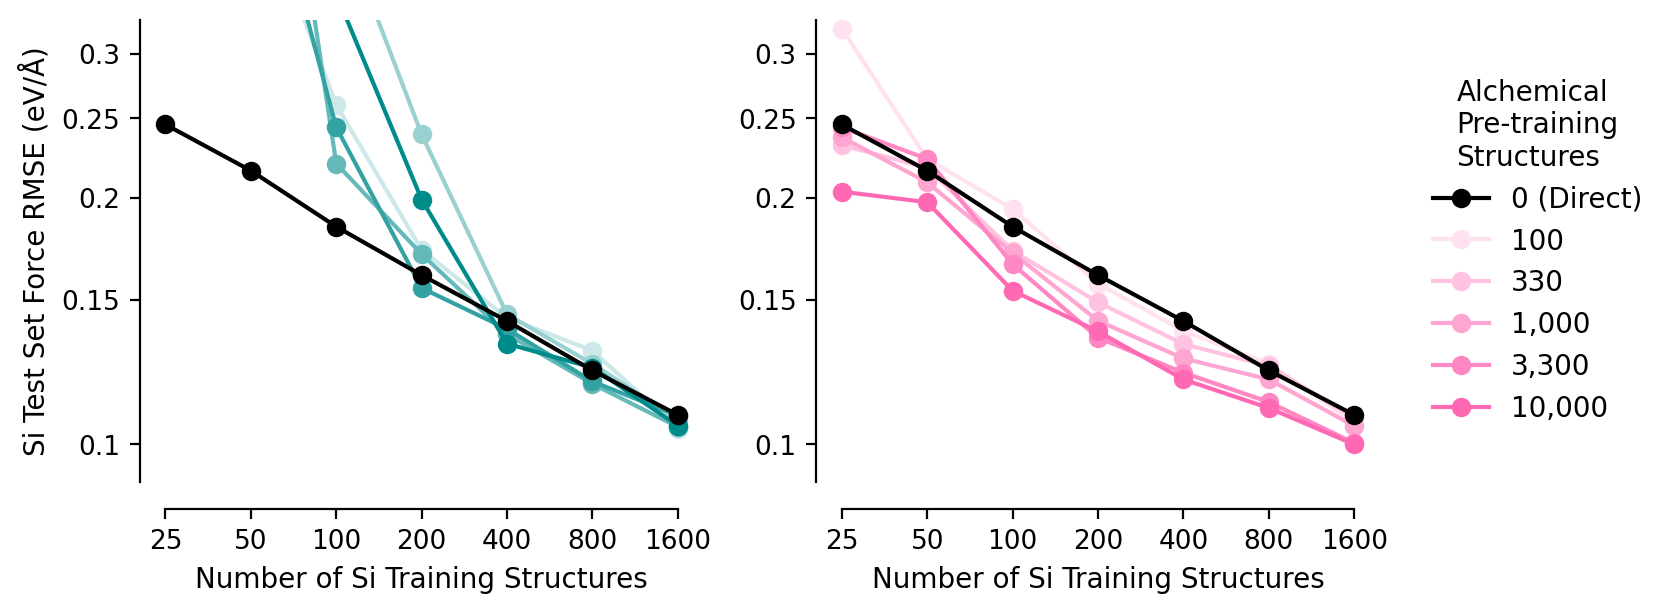

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

for ax in axs:
    ax.plot(
        direct_results.n_train,
        direct_results.test_force_rmse,
        "-ok",
        label="0 (Direct)",
        zorder=10,
    )

    xticks = list(direct_results.n_train)
    yticks = [0.1, 0.15, 0.2, 0.25, 0.3]
    log_log(xticks=xticks, yticks=yticks, ax=ax)
    ax.spines["bottom"].set_position(("outward", 10))
    ax.spines["bottom"].set_bounds(xticks[0], xticks[-1])

    ax.set_xlabel("Number of Si Training Structures")
    ax.set_ylim(0.09, 0.33)

# add null result: scale factor = 1.5, r_max = 6
# (i.e. wildly different #s of atoms in the local environment)
add_finetune_results(
    pretrain_config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        labels="ace",
        scale_factor=1.5,
        r_max=6,
    ),
    ax=axs[0],
    color="darkcyan",
)

# add positive result: scale factor = 1.5, r_max = 4
add_finetune_results(
    pretrain_config=dict(
        dataset_name="C-SYNTH-23M:reasonable",
        labels="ace",
        scale_factor=1.5,
        r_max=4,
    ),
    ax=axs[1],
)

axs[0].set_ylabel("Si Test Set Force RMSE (eV/Å)")
axs[1].legend(
    title="Alchemical\nPre-training\nStructures",
    bbox_to_anchor=(1.05, 0.5),
    loc="center left",
)

plt.savefig("../figures/alchemy-curves.svg", bbox_inches="tight", transparent=True)

# Table

In [4]:
positive_transfer_config = {
    "dataset_name": "C-SYNTH-23M:reasonable",
    "labels": "ace",
    "scale_factor": 1.5,
    "r_max": 6,
}
pre_trained_results = alchemical_train.to_dataframe(
    config=positive_transfer_config
).sort_values("n_train")
pre_trained_models = list(pre_trained_results.id)
pre_trained_models

['23.06.28-19.46.50-432517',
 '23.06.28-22.39.25-814269',
 '23.06.29-01.26.15-690272',
 '23.06.29-14.11.44-365373',
 '23.07.01-12.07.30-671895']

In [5]:
import pandas as pd


fine_tuned_results = pd.concat(
    [
        fine_tuning.to_dataframe(
            config=dict(
                pretrain_id=id,
                finetune_dataset="Si-GAP-18",
                finetune_labels="dft",
                r_max=4,
            )
        )
        for id in pre_trained_models
    ]
)

# join with the pre-trained results to get the number of pre-training structures
fine_tuned_results = fine_tuned_results.merge(
    pre_trained_results[["id", "n_train"]], left_on="pretrain_id", right_on="id"
)

columns = ["n_train", "n_finetune", "test_force_rmse", "seed"]
fine_tuned_results = fine_tuned_results[columns]
# rename n_train to n_pretrain
fine_tuned_results = fine_tuned_results.rename(columns={"n_train": "n_pretrain"})

fine_tuned_results.groupby(["n_pretrain", "n_finetune"])[
    "test_force_rmse"
].count().unstack()

n_finetune,25,50,100,200,400,800,1600
n_pretrain,,,,,,,
100,3,3,3,3,3,3,3
330,3,3,3,3,3,3,3
1000,3,3,3,3,3,3,3
3300,3,3,3,3,3,3,3
10000,3,3,3,3,3,3,3


In [6]:
# get the mean and standard deviation for each combination of n_pretrain and n_finetune
df = (
    fine_tuned_results.groupby(["n_pretrain", "n_finetune"])
    .agg(["mean", "std"])
    .round(4)["test_force_rmse"]
)
(df["mean"].astype(str) + " ± " + df["std"].astype(str)).unstack()

n_finetune,25,50,100,200,400,800,1600
n_pretrain,,,,,,,
100,1.4306 ± 1.1654,0.568 ± 0.0764,0.3038 ± 0.0658,0.1821 ± 0.0155,0.1442 ± 0.0021,0.133 ± 0.0032,0.1154 ± 0.016
330,4.9574 ± 1.8385,2.584 ± 0.2244,0.475 ± 0.0269,0.5278 ± 0.3956,0.1491 ± 0.0044,0.1269 ± 0.0014,0.1141 ± 0.0063
1000,0.8623 ± 0.2585,1.9938 ± 0.7919,0.3944 ± 0.2535,0.1963 ± 0.0268,0.1384 ± 0.0032,0.1214 ± 0.0025,0.1073 ± 0.0034
3300,1.2953 ± 0.5186,1.7182 ± 1.6392,0.9074 ± 0.6838,0.4093 ± 0.3829,0.1525 ± 0.0127,0.1242 ± 0.0043,0.1101 ± 0.0015
10000,1.7191 ± 0.6075,1.6623 ± 1.7241,0.3828 ± 0.045,0.213 ± 0.0143,0.1451 ± 0.0107,0.1297 ± 0.0051,0.107 ± 0.0017


In [7]:
# get the same data for the direct training results
direct_results = direct_training.to_dataframe(
    config=dict(
        dataset_name="Si-GAP-18",
        labels="dft",
        r_max=4,
    )
).sort_values("n_train")

df = (
    direct_results[["test_force_rmse", "n_train"]]
    .groupby("n_train")
    .agg(["mean", "std"])
    .round(4)
)["test_force_rmse"]

pd.DataFrame(df["mean"].astype(str) + " ± " + df["std"].astype(str)).T

n_train,25,50,100,200,400,800,1600
0,0.2659 ± 0.0199,0.225 ± 0.008,0.203 ± 0.017,0.1645 ± 0.0047,0.1436 ± 0.0033,0.1292 ± 0.0055,0.1096 ± 0.0011


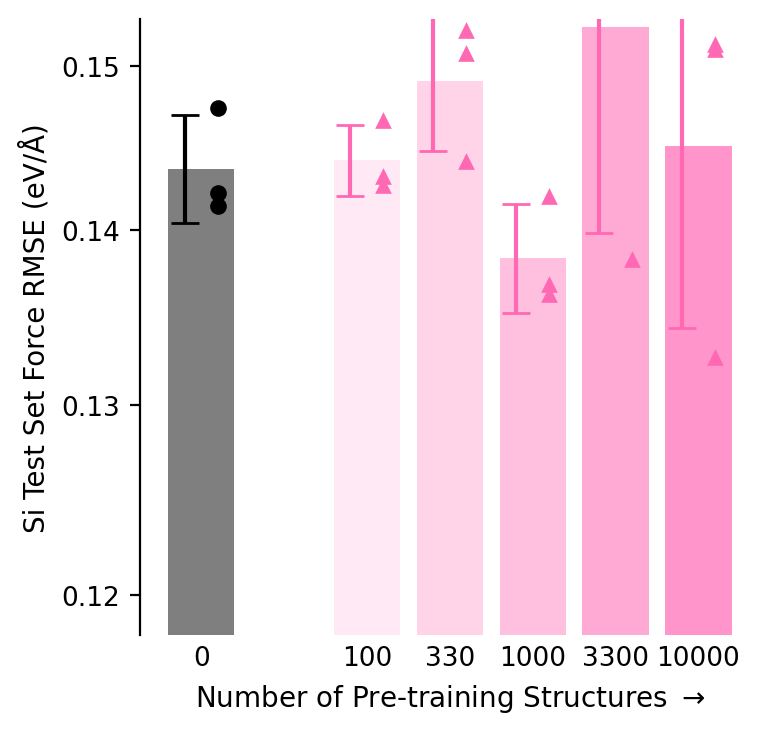

In [9]:
# bar chart

n_pretrains = [100, 330, 1_000, 3_300, 10_000]
cmap = LinearSegmentedColormap.from_list("mycmap", ["white", "hotpink"])

gradient = cmap(np.linspace(0.2, 1, len(n_pretrains)))
color_gradient = dict(zip(n_pretrains, gradient))

n_train = 400

direct_err = direct_results[direct_results.n_train == n_train].test_force_rmse
plt.bar(0, direct_err.mean(), color="k", alpha=0.5)
plt.errorbar(-0.2, direct_err.mean(), yerr=direct_err.std(), color="k", capsize=5)
plt.scatter([0.2] * len(direct_err), direct_err, c="k", lw=0)

for i, n_pretrain in enumerate([100, 330, 1000, 3300, 10000]):
    err = fine_tuned_results[
        (fine_tuned_results.n_pretrain == n_pretrain)
        & (fine_tuned_results.n_finetune == n_train)
    ].test_force_rmse
    plt.bar(i + 2, err.mean(), color=color_gradient[n_pretrain], alpha=0.7)
    plt.errorbar(i + 2 - 0.2, err.mean(), yerr=err.std(), color="hotpink", capsize=5)
    plt.scatter([i + 2 + 0.2] * len(err), err, c="hotpink", marker="^", lw=0)

plt.xticks([0, 2, 3, 4, 5, 6], ["0", "100", "330", "1000", "3300", "10000"])
plt.ylabel("Si Test Set Force RMSE (eV/Å)")
plt.xlabel(r"Number of Pre-training Structures $\rightarrow$")
plt.gca().spines["bottom"].set_visible(False)
# make actual tick marks invisible
plt.gca().tick_params(axis="x", length=0)

plt.yscale("log")
# yticks = [0.16, 0.17, 0.18, 0.19, 0.20, 0.21, 0.22]
yticks = [0.12, 0.13, 0.14, 0.15]
plt.yticks(yticks, [f"{y:.2f}" for y in yticks])
plt.ylim(0.118, 0.153)

# plt.title("400 Si-GAP-18 Training Structures")
plt.minorticks_off()

plt.savefig("../figures/alchemy-bar.svg", bbox_inches="tight", transparent=True)

# SOAP UMAP plots

In [10]:
from ase.io import read

# normal structures
unscaled_c = read(
    "../data/processed/C-SYNTH-23M:reasonabletransmuted:Si-1.0/ace/test.extxyz",
    index=":",
)

# scaled structures
scaled_c = read(
    "../data/processed/C-SYNTH-23M:reasonabletransmuted:Si-1.5/ace/test.extxyz",
    index=":",
)

# true si structures
si = read("../data/processed/Si-GAP-18/dft/test.extxyz", index=":")

In [11]:
len(unscaled_c), len(scaled_c), len(si)


(1000, 1000, 247)

In [12]:
import numpy as np
from quippy.descriptors import Descriptor

soap_desc = Descriptor("soap cutoff=4.0 l_max=6 n_max=6 atom_sigma=0.5 n_Z=1 Z={14}")

unscaled_soaps = np.vstack([soap_desc.calc_descriptor(atoms) for atoms in unscaled_c])
scaled_soaps = np.vstack([soap_desc.calc_descriptor(atoms) for atoms in scaled_c])
si_soaps = np.vstack([soap_desc.calc_descriptor(atoms) for atoms in si])

unscaled_soaps.shape, scaled_soaps.shape, si_soaps.shape


((200000, 148), (200000, 148), (17295, 148))

In [16]:
from umap import UMAP


umap = UMAP(n_components=2, random_state=42, n_neighbors=4)

representative_idxs = np.random.RandomState(42).choice(len(si_soaps), size=5000, replace=False)

c_embedding = umap.fit_transform(
    np.vstack(
        [
            unscaled_soaps[representative_idxs],
            scaled_soaps[representative_idxs],
        ]
    ),
)
si_embedding = umap.transform(si_soaps[representative_idxs])

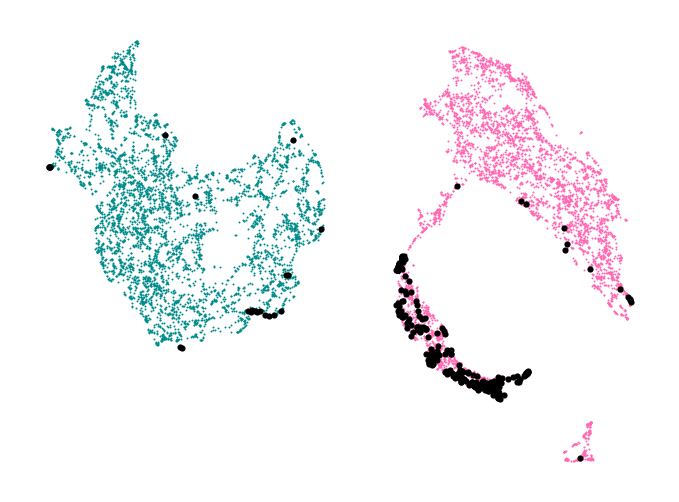

In [ ]:
plt.figure(figsize=(6, 3))

n_to_plot = 5_000
plt.scatter(
    *c_embedding[:n_to_plot].T,
    s=0.5,
    lw=0,
    label="Unscaled C",
    c="darkcyan",
)
plt.scatter(
    *c_embedding[5000 : 5000 + n_to_plot :].T,
    s=0.5,
    lw=0,
    label="Scaled C",
    c="hotpink",
)
plt.scatter(*si_embedding[:400].T, s=5, lw=0, label="Si", c="k")

plt.gca().set_aspect("equal")
plt.axis("off")
plt.gca().invert_xaxis()

plt.savefig("../figures/alchemy-umap.svg", bbox_inches="tight", transparent=True)